In [17]:
import torch
import PIL
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import natsort
import glob
import cv2
import os
import matplotlib.patches as patches
import numpy as np
import time
from scipy import io

import torch.nn as nn
import torchvision.transforms.functional as TF
from PIL import Image
from torchvision import datasets, models, transforms

In [18]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet34'
        self.model=models.resnet34(pretrained=True)
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

KeyboardInterrupt: 

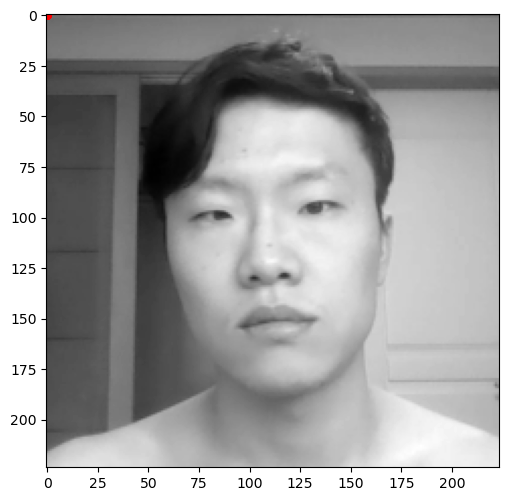

In [19]:
net = cv2.dnn.readNetFromCaffe('./openCV_models/deploy.prototxt.txt',
                               './openCV_models/res10_300x300_ssd_iter_140000.caffemodel')
network_pro = Network()
network_pro.cuda()
network_pro.load_state_dict(torch.load('./LandmarkModel_pts_3d.pth'))
network_pro.eval()

save_dir = './webcamTest'

start = time.time()
cap = cv2.VideoCapture('./Pictures/Camera Roll/WIN_20211114_09_58_19_Pro.mp4')
i = 0
widthh = 0; heightt = 0; tt = 0; ll = 0;
fig = []
while(cap.isOpened()) :
    ret, frame = cap.read()
    
    if ret == False:
        break
        
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300,300)), 1.0, (300,300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()

    box = detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
    (l, t, r, b) = box.astype("int")
    # Crop
    width = (r-l)
    height = (b-t)
    if(width > height) :
        widthh = width*1.5
        heightt = widthh
        tt = t + height*0.5 - heightt*0.5
        ll = l - width*0.25
    else :
        heightt = height*1.5
        widthh = heightt
        tt = t - height*0.25
        ll = l + width*0.5 - widthh*0.5
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = Image.fromarray(frame)
    frame = TF.crop(frame, tt, ll, heightt, widthh)
    frame = TF.resize(frame, (224,224))
    frame = TF.to_tensor(frame)
    frame = TF.normalize(frame, [0.5], [0.5])
    frame = frame.unsqueeze(1)
    frame = frame.cuda()
    
    predictions_pro = (network_pro(frame).cpu())
    predictions_pro = predictions_pro.view(-1, 68, 2)
    
    #predictions_pre = (network_pre(frame).cpu() + 0.5) * 224
    #predictions_pre = predictions_pre.view(-1, 68, 2)
    
    
    fig.insert(i, plt.figure(figsize=(600/100, 600/100), dpi=100))
    plt.scatter(predictions_pro[0, :, 0].detach().numpy(), predictions_pro[0, :, 1].detach().numpy(), c = 'red', s = 10)
    plt.imshow(frame.cpu().squeeze(), cmap='gray')
    plt.savefig(save_dir + '/' + str(i) + '.jpg')
    plt.clf()
    plt.close()
    
    #fig.insert(i, plt.figure(figsize=(600/100, 600/100), dpi=100))
    #plt.scatter(predictions_pre[0, :, 0].detach().numpy(), predictions_pre[0, :, 1].detach().numpy(), c = 'green', s = 10)
    #plt.imshow(frame.cpu().squeeze(), cmap='gray')
    #plt.savefig(save_dir + '/' + str(i+60) + '.jpg')
    #plt.clf()
    #plt.close()
    i += 1
    
print("Time : " , time.time()-start, " for ", i , " Frames")
cap.release()
cv2.destroyAllWindows()